## Binary classification based on fully connected neural network

In [11]:
# -----------------------------------------------------------------------------
# import packages
# -----------------------------------------------------------------------------

import matplotlib.pyplot as plt
import numpy as np

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision

from torchvision import datasets, transforms
from torch.autograd import Variable
from random import shuffle

import argparse
import sys
import os
import numpy as np
import time
import datetime
import csv
import configparser
import argparse
import platform

### Neural Network Architecture

In [12]:
class Linear(nn.Module):

    def __init__(self, num_classes=2):

        super(Linear, self).__init__()

        self.number_class = num_classes

        _size_image = 100 * 100
        _num1 = 150
        _num2 = 50

        self.fc1 = nn.Linear(_size_image, _num1, bias=True)
        self.fc2 = nn.Linear(_num1, _num2, bias=True)
        self.fc3 = nn.Linear(_num2, num_classes, bias=True)

        self.fc_layer1 = nn.Sequential(self.fc1, nn.LeakyReLU(True))
        self.fc_layer2 = nn.Sequential(self.fc2, nn.LeakyReLU(True))
        self.fc_layer3 = nn.Sequential(self.fc3, nn.Sigmoid())

        self.classifier = nn.Sequential(self.fc_layer1, self.fc_layer2, self.fc_layer3)

        self._initialize_weight()

    def _initialize_weight(self):
        for name, m in self._modules.items():
            if isinstance(m, nn.Linear):
                n = m.in_features
                m.weight.data.uniform_(- 1.0 / math.sqrt(n), 1.0 / math.sqrt(n))

                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):

        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x

In [13]:
# -----------------------------------------------------------------------------
# function for draw table
# -----------------------------------------------------------------------------
def output_frame_plot(tloss, vloss, tacc, vacc, title):
    print(" << %s >>" % title)
    print("------------------------------------------------------")
    print("                |   %10s    |    %10s     |" % ('loss', 'accuracy'))
    print("------------------------------------------------------")
    print("training        |   %.10f   |    %.10f    |" % (tloss, tacc))
    print("------------------------------------------------------")
    print("validation      |   %.10f   |    %.10f    |" % (vloss, vacc))
    print("------------------------------------------------------")


def output_plot(g1, g2, std, title, color, label, legend):
    plt.title(title)
    plt.plot(np.arange(1, len(g1) + 1), g1, color=color[0], alpha=0.5, label=label[0])
    plt.plot(np.arange(1, len(g2) + 1), g2, color=color[1], alpha=0.5, label=label[1])
    if std is not None:
        plt.fill_between(np.arange(1, len(g1)+1),
                         np.array(g1)-np.array(std),
                         np.array(g1)+np.array(std), color=color[0], alpha=0.3)
    plt.legend(loc=legend)
    plt.show()

### Loss function  and Implementation


$\mathcal{L} = \frac{1}{n} \sum_{i=1}^n f_i + \frac{\lambda}{2} \left( \| W \|_2^2 \right)$

- Cross Entropy : 
    $f_i = - y_i \log \hat{y}_i - (1 - y_i) \log (1 - \hat{y}_i) $, where $y_i$ denotes the ground truth and $\hat{y}_i$ denotes the output of the network

- Regularization : 
    $\| W \|_2^2 = \left( \sum_i w_{i}^2 \right)$, where $w_{i}$ denotes all the model parameters

In [8]:
IMAGE_WIDTH = 100
IMAGE_HEIGHT = 100
IMAGE_CHANNEL = 1
DIMENSION = IMAGE_CHANNEL * IMAGE_HEIGHT * IMAGE_WIDTH

# global settings
# torch.set_default_dtype(torch.float64)
# torch.set_default_tensor_type('torch.cuda.DoubleTensor')
torch.set_printoptions(precision=16)
torch.cuda.set_device(0)

# setting check
print("current device : %s" % (torch.cuda.current_device()))
print("device count : %s" % (torch.cuda.device_count()))
print("device name : %s" % (torch.cuda.get_device_name(0)))
print("CUDA available? : %s" % (torch.cuda.is_available()))

batch_size = 30

# -----------------------------------------------------------------------------
# load dataset
# -----------------------------------------------------------------------------

transform = transforms.Compose([  # transforms.Resize((256,256)),
    transforms.Grayscale(),
    # the code transforms.Graysclae() is for changing the size [3,100,100] to [1, 100, 100] (notice : [channel, height, width] )
    transforms.ToTensor(), ])

# train_data_path = 'relative path of training data set'
# change the valuse of batch_size, num_workers for your program
# if shuffle=True, the data reshuffled at every epoch
train_data_path = './horse-or-human/train'
validation_data_path = './horse-or-human/validation'

set_train = torchvision.datasets.ImageFolder(root=train_data_path, transform=transform)
set_test = torchvision.datasets.ImageFolder(root=validation_data_path, transform=transform)

loader_train = torch.utils.data.DataLoader(
    dataset=set_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=5
)

loader_test = torch.utils.data.DataLoader(
    dataset=set_test,
    batch_size=batch_size,
    shuffle=False,
    num_workers=5
)

num_classes = 2

# -----------------------------------------------------------------------------
# load neural network model
# -----------------------------------------------------------------------------

model = Linear(num_classes=num_classes)

# -----------------------------------------------------------------------------
# Set the flag for using cuda
# -----------------------------------------------------------------------------
model.cuda()

# torch.backends.cudnn.benchmark = True
# torch.set_default_tensor_type('torch.cuda.FloatTensor')


# -----------------------------------------------------------------------------
# optimization algorithm
# -----------------------------------------------------------------------------
learning_rate = 0.5
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.093)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.25, patience=30, min_lr=0.001, verbose=True)
objective = nn.CrossEntropyLoss()


# -----------------------------------------------------------------------------
# function for training the model
# -----------------------------------------------------------------------------

def train():
    # print('train the model at given epoch')

    loss_train = []
    acc_train = []

    model.train()

    for idx_batch, (data, target) in enumerate(loader_train):

        if len(data) % batch_size != 0:
            continue

        correct = 0

        data, target = data.cuda(), target.cuda()
        data, target = Variable(data).cuda(), Variable(target).cuda()

        optimizer.zero_grad()

        output = model(data)
        loss = objective(output, target)

        loss.backward()
        optimizer.step()

        loss_train_batch = loss.item() / len(data)
        loss_train.append(loss_train_batch)

        pred = output.data.max(1)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        acc_train.append(100. * float(correct) / len(data))

    loss_train_mean = np.mean(loss_train)
    loss_train_std = np.std(loss_train)
    acc_train_mean = np.mean(acc_train)
    acc_train_std = np.std(acc_train)

    return {'loss_train_mean': loss_train_mean,
            'loss_train_std': loss_train_std,
            'accuracy_train_mean': acc_train_mean,
            'accuracy_train_std': acc_train_std}


# -----------------------------------------------------------------------------
# function for testing the model
# -----------------------------------------------------------------------------

def test():
    # print('test the model at given epoch')
    loss_test = 0
    correct = 0

    model.eval()

    for idx_batch, (data, target) in enumerate(loader_test):

        data, target = data.cuda(), target.cuda()
        data, target = Variable(data).cuda(), Variable(target).cuda()

        output = model(data)
        loss = objective(output, target)

        loss_test += loss.item()
        pred = output.data.max(1)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    loss_test = loss_test / len(loader_test.dataset)
    accuracy_test = 100. * float(correct) / len(loader_test.dataset)

    return {'loss_test': loss_test, 'accuracy_test': accuracy_test}


# -----------------------------------------------------------------------------
# iteration for the epoch
# -----------------------------------------------------------------------------

loss_train_mean, loss_train_std, loss_test, accuracy_train_std, accuracy_test, accuracy_train = [], [], [], [], [], []
prev_train_loss, next_train_loss = 0, 0

for e in range(5000):
    result_train = train()
    result_test = test()

    next_train_loss = result_train['loss_train_mean']

    loss_train_mean.append(result_train['loss_train_mean'])
    loss_train_std.append(result_train['loss_train_std'])
    loss_test.append(result_test['loss_test'])

    accuracy_train.append(result_train['accuracy_train_mean'])
    accuracy_train_std.append(result_train['accuracy_train_std'])
    accuracy_test.append(result_test['accuracy_test'])

    print("[epoch %s] loss: (training) %s, (testing) %s, accuracy: (training) %s, (testing) %s" %
          (e, loss_train_mean[-1], loss_test[-1], accuracy_train[-1], accuracy_test[-1]))

    if abs(next_train_loss - prev_train_loss) < 10e-8:
        break
    else:
        prev_train_loss = next_train_loss
        scheduler.step(result_test['accuracy_test'], e)

current device : 0
device count : 1
device name : GeForce RTX 2060
CUDA available? : True
[epoch 0] loss: (training) 0.022681362956177953, (testing) 0.02383565134368837, accuracy: (training) 56.27450980392157, (testing) 50.0
[epoch 1] loss: (training) 0.022729988542257572, (testing) 0.023642352782189846, accuracy: (training) 55.392156862745104, (testing) 50.0
[epoch 2] loss: (training) 0.02230165080696929, (testing) 0.02332209306769073, accuracy: (training) 59.01960784313726, (testing) 50.0
[epoch 3] loss: (training) 0.02223628893786786, (testing) 0.023778158240020275, accuracy: (training) 57.64705882352941, (testing) 50.0
[epoch 4] loss: (training) 0.022542530531976735, (testing) 0.02349218726158142, accuracy: (training) 59.90196078431373, (testing) 85.546875
[epoch 5] loss: (training) 0.02230632842755785, (testing) 0.022709327517077327, accuracy: (training) 60.588235294117645, (testing) 50.390625
[epoch 6] loss: (training) 0.021984822551409405, (testing) 0.02205603988841176, accuracy

[epoch 59] loss: (training) 0.020453464984893796, (testing) 0.019548533484339714, accuracy: (training) 68.72549019607844, (testing) 78.90625
[epoch 60] loss: (training) 0.02027269134334489, (testing) 0.01911319326609373, accuracy: (training) 70.09803921568627, (testing) 80.859375
[epoch 61] loss: (training) 0.020389368312031614, (testing) 0.018666207557544112, accuracy: (training) 69.01960784313725, (testing) 80.078125
[epoch 62] loss: (training) 0.020183263339248355, (testing) 0.018801587051711977, accuracy: (training) 69.01960784313727, (testing) 77.734375
Epoch    62: reducing learning rate of group 0 to 3.1250e-02.
[epoch 63] loss: (training) 0.019335907814549462, (testing) 0.01752426160965115, accuracy: (training) 77.15686274509802, (testing) 86.328125
[epoch 64] loss: (training) 0.019052692020640655, (testing) 0.016937735374085605, accuracy: (training) 77.45098039215685, (testing) 88.28125
[epoch 65] loss: (training) 0.018946075906940536, (testing) 0.017198347486555576, accuracy:

[epoch 117] loss: (training) 0.017619421785952997, (testing) 0.016139808343723416, accuracy: (training) 83.23529411764706, (testing) 87.890625
[epoch 118] loss: (training) 0.017545181629704493, (testing) 0.01594004046637565, accuracy: (training) 83.62745098039215, (testing) 87.890625
[epoch 119] loss: (training) 0.01759124716707304, (testing) 0.01730201137252152, accuracy: (training) 82.94117647058823, (testing) 81.640625
[epoch 120] loss: (training) 0.01757557228499768, (testing) 0.015828016214072704, accuracy: (training) 83.62745098039215, (testing) 88.671875
[epoch 121] loss: (training) 0.017490273012834436, (testing) 0.01590270921587944, accuracy: (training) 83.72549019607843, (testing) 88.28125
[epoch 122] loss: (training) 0.017526231735360387, (testing) 0.01606000622268766, accuracy: (training) 83.43137254901961, (testing) 87.890625
[epoch 123] loss: (training) 0.017506591917253008, (testing) 0.016379488515667617, accuracy: (training) 83.62745098039215, (testing) 85.9375
[epoch 1

[epoch 175] loss: (training) 0.017368825481218455, (testing) 0.016205697786062956, accuracy: (training) 83.92156862745097, (testing) 87.890625
[epoch 176] loss: (training) 0.017356425494539973, (testing) 0.0162063913885504, accuracy: (training) 84.41176470588233, (testing) 87.890625
[epoch 177] loss: (training) 0.01735456442716075, (testing) 0.016305734869092703, accuracy: (training) 84.21568627450979, (testing) 86.71875
[epoch 178] loss: (training) 0.017348071757484883, (testing) 0.01614807767327875, accuracy: (training) 84.50980392156863, (testing) 87.890625
[epoch 179] loss: (training) 0.01737669393712399, (testing) 0.01615985913667828, accuracy: (training) 83.92156862745097, (testing) 87.890625
[epoch 180] loss: (training) 0.017376999790761984, (testing) 0.01610675430856645, accuracy: (training) 84.50980392156863, (testing) 87.890625
[epoch 181] loss: (training) 0.017353053274107914, (testing) 0.0162190452683717, accuracy: (training) 84.01960784313725, (testing) 87.890625
[epoch 18

[epoch 233] loss: (training) 0.0173129680109959, (testing) 0.01623458042740822, accuracy: (training) 84.50980392156863, (testing) 87.5
[epoch 234] loss: (training) 0.017338348048574787, (testing) 0.016171899740584195, accuracy: (training) 84.21568627450979, (testing) 87.890625
[epoch 235] loss: (training) 0.017327940873071258, (testing) 0.016214708448387682, accuracy: (training) 84.41176470588235, (testing) 87.890625
[epoch 236] loss: (training) 0.017316822882960825, (testing) 0.016144066117703915, accuracy: (training) 84.70588235294117, (testing) 87.890625
[epoch 237] loss: (training) 0.01732420430463903, (testing) 0.016213038354180753, accuracy: (training) 84.50980392156862, (testing) 87.890625
[epoch 238] loss: (training) 0.017278977118286434, (testing) 0.01615469006355852, accuracy: (training) 84.50980392156862, (testing) 87.890625
[epoch 239] loss: (training) 0.017306664352323496, (testing) 0.016060925903730094, accuracy: (training) 85.09803921568628, (testing) 87.890625
[epoch 24

### Plot

In [9]:
output_frame_plot(loss_train_mean[-1], loss_test[-1], accuracy_train[-1], accuracy_test[-1], "Result")

 << Result >>
------------------------------------------------------
                |         loss    |      accuracy     |
------------------------------------------------------
training        |   0.0173076500   |    84.6078431373    |
------------------------------------------------------
validation      |   0.0162016819   |    87.8906250000    |
------------------------------------------------------


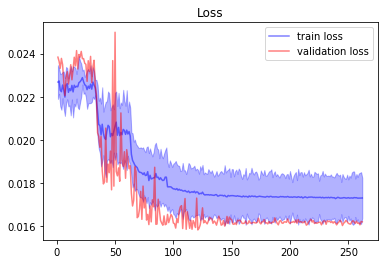

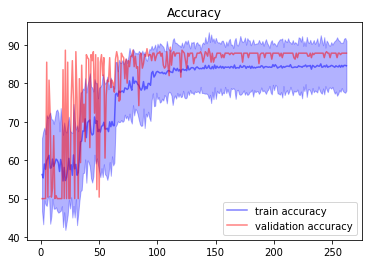

In [10]:
output_plot(loss_train_mean, loss_test, std=loss_train_std, title="Loss", color=('blue', 'red'),
            label=('train loss', 'validation loss'), legend='upper right')
output_plot(accuracy_train, accuracy_test, std=accuracy_train_std, title="Accuracy", color=('blue', 'red'),
            label=('train accuracy', 'validation accuracy'), legend='lower right')